In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [4]:
import sklearn
sklearn.__version__

'0.19.1'

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default plot sizes
plt.rcParams['image.interpolation']  = 'nearest' # User nearest neighbor for rendering small size images.

In [6]:
#Allowing notebooks to reload external python modules; 
#Details: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Reading and Visualizing the  data

In [7]:
# Dataset : CIFAR
# using picke to open the CIFAR dataset

def unpickle(file):
    open_file = open(file,'rb')
    data = pickle.load(open_file, encoding = "bytes")
    return data

In [8]:
xtrain = []
ytrain = []

file = 'cifar/data_batch_1'
opened_file = unpickle(file)
x = opened_file[b'data'] # Getting access to the raw file

#Each batch of CIFAR has 10,000 images. Each image  = 32*32 bits with 3 channels
x_image = x.reshape(10000,3,32,32)
x_image = x_image.transpose(0,2,3,1).astype('float')

#Open label files
y =  np.array(opened_file[b'labels'])

Planes


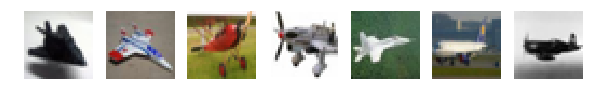

In [9]:
classes = {"Plane":0,"Car":1,"Bird":2,"Cat":3,"Deer":4,"Dog":5,"Frog":6,"Horse":7,"Ship":8,"Truck":9}

#Location of the picture of a particular class
y_location = np.where(y == classes["Plane"])

number_of_samples = 7
#Get few images of the particular class. Image sample index = Indices of the number of selected samples
image_sample_index = y_location[0][0:number_of_samples]

plot_location = 1
print("Planes")
for j in image_sample_index:
    plt.subplot(1,number_of_samples,plot_location)
    plt.imshow(x_image[j].astype('uint8'))
    plt.axis('off')
        
    #Plot_location is for managing the location of the image rendered
    # First image is at offset 1, second at offset 2 etc.
    plot_location = plot_location + 1
plt.show()

## Data preparation

Here we will prepare a training set containing images of the object we selected to be identified e.g planes and other objects that are not planes

In [10]:
y_target_location = np.where(y == classes["Plane"])
y_other_location = np.where(y != classes['Plane'])

In [11]:
x_train = np.append(x_image[y_target_location[0][0:100], ],x_image[y_other_location[0][0:100], ], axis = 0)
y_train = np.append(np.ones([100,1]), np.zeros([100,1]))

In [12]:
x_test = np.append(x_image[y_target_location[0][100:120], ],x_image[y_other_location[0][100:120], ], axis = 0)
y_test = np.append(np.ones([20,1]), np.zeros([20,1]))

Take a look at the dimensions of the training and the test images

In [13]:
np.shape(x_train)

(200, 32, 32, 3)

In [14]:
print("Number of training examples",x_train.shape[0])
print("Shape of a training images: %d x %d x %d" %(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
print("Number of test examples",x_test.shape[0])
print("Shape of a test images: %d x %d x %d" %(x_test.shape[1],x_test.shape[2],x_test.shape[3]))


Number of training examples 200
Shape of a training images: 32 x 32 x 3
Number of test examples 40
Shape of a test images: 32 x 32 x 3


Next step is to flatten the images

In [15]:
x_train_flat = x_train.reshape(x_train.shape[0],-1).T
x_test_flat = x_test.reshape(x_test.shape[0],-1).T

In [16]:
print("Shape of flattened training set: ", x_train_flat.shape)
print("Shape of flattened test set: ", x_test_flat.shape)

Shape of flattened training set:  (3072, 200)
Shape of flattened test set:  (3072, 40)


Next normalize the data by subtracting the mean and dividing by the standard deviation

In [17]:
xmean = np.mean(x_train_flat)
xstdev = np.std(x_train_flat)
x_train_flat = (x_train_flat - xmean)/xstdev
x_test_flat = (x_test_flat - xmean)/xstdev

## Build a simple perceptron model with logistic regression classifier

In [18]:
# sigmoid function:

def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

In [29]:
#Building Forward propagation

def fwd_prop(W1,B1,W2,B2,X,Y):
    
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0]
      
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1
    A1 = sigmoid(Z1)
    
    # A1 = (n_1,m)
    # W2 = (n_2,n_1) = (1,n_1) [n_2 = 1 because last layer has only 1 node]  
    # B2 = (n_2,1) -> Broadcast -> (n_2,m) = (1,m)
    # Z2 = (n_2,m) = (1,m)
    # A2 = (n_2,m) = (1,m)
    Z2 = np.dot(W2,A1) + B2
    A2 = sigmoid(Z2)
    
    return(A2,A1)
    

In [37]:
def back_prop(A2,A1,W1,B1,W2,B2,X,Y):
    
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0]
    
    #Matching dimensions
    # Y = (1,m)
    # A2 = (1,m)
    # Loss = (1,m)
    cost = (1/m) * ( np.sum(Y*np.log(A2) + (1-Y)*np.log(1-A2)))
        
    #dA2 = shape(A2) = (n_2,m) = (1,m) [n_2 = 1 because last layer has only 1 node]    
    dA2 = Y/A2 + (1-Y)/(1-A2)
    
    #dZ2  = shape(Z2) = (n_2,m) = (1,m)
    dZ2 = A2 - Y
    
    #dW2 = shape(W2) = (n_2,n_1) = (1, n_1)
    dW2 = np.dot(dZ2,A1.T)
    
    #dB2 = (n_2,1) = (1,1)
    dB2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True)
    
    #dA1 = (n_1,m) { W2:(n_2,n_1), dZ2:(n_2,m)}
    dA1 = np.dot(W2.T,dZ2)
    
    #dZ1 = (n_1,m)
    dZ1 = dA1*((1-A1)*A1)
    
    #dW1 = (n_1,n_0)
    dW1 = np.dot(dZ1,X.T) #{dZ1:(n_1,m), X:(n_0,m)}
    
    #dB1 = (n_1,1)
    dB1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)
    
    
    return(dW1, dB1, dW2, dB2, cost)

In [21]:
def update_weights(dW1, dB1, W1, B1,dW2, dB2, W2, B2, learning_rate):
    W1 = W1 - learning_rate*dW1
    W2 = W2 - learning_rate*dW2
    B1 = B1 - learning_rate*B1
    B2 = B2 - learning_rate*B2

In [22]:
def run_nn(num_iterations, learning_rate):
    
    for i in np.arange(num_iterations):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-22-b03700655186>, line 4)

In [60]:
def run_iterations(X,Y,num_iterations, learning_rate):
    n_0 = np.shape(X)[0]
    m = np.shape(X)[1]
    n_1 = 20
    n_2 = 1
    
    W1 = np.random.random([n_1,n_0])
    B1 = np.zeros([n_1,1])
    W2 = np.random.random([n_2,n_1])
    B2 = np.zeros([n_2,1])
    
    loss_array = np.ones([num_iterations])*np.nan
    
    for i in np.arange(num_iterations):
        A2, A1 = fwd_prop(W1,B1,W2,B2,X,Y)
        dW1, dB1, dW2, dB2, cost = back_prop(A2,A1,W1,B1,W2,B2,X,Y)
        
        loss_array[i] = cost
        W1 = W1 - learning_rate*dW1
        W2 = W2 - learning_rate*dW2
        B1 = B1 - learning_rate*B1
        B2 = B2 - learning_rate*B2
            
    return(W1,B1,W2,B2,loss_array)

0.5

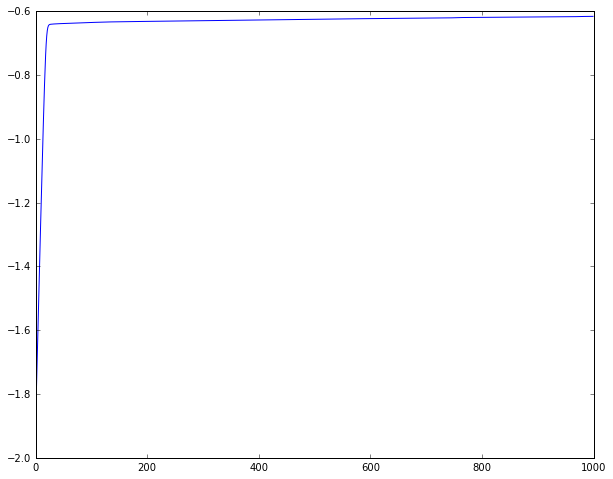

In [64]:
W1,B1,W2,B2,loss_array = run_iterations(x_train_flat,y_train,1000,0.001)
y_predict,ignore = fwd_prop(W1,B1,W2,B2,x_test_flat,y_test)

plt.plot(loss_array)

temp = y_predict.copy()
temp[temp>=0.5] = 1
temp[temp<0.5] = 0

np.sum(temp == y_test)/len(y_test)

In [66]:
temp

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.]])

In [55]:
y_test

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])